# Twitch Insight: Data Collector & Collaboration Network Analyzer (v3 - Enhanced Prints)

This notebook automates the process of collecting data from the Twitch API, store it in a local SQLite database, and perform analysis, with a special focus on understanding collaboration networks between streamers. It identifies potential collaborations by detecting `@mentions` in video titles and descriptions, and also explores community structures within these networks. The primary interface for data collection, processing, and exploration is a Jupyter Notebook.

**Key Features:**
- Fetches top streams/categories periodically.
- Fetches channel details and video archives.
- Processes video titles/descriptions for `@mentions`.
- Looks up mentioned users via API if not in the database.
- Stores collaboration data (frequency, duration, recency).
- Processes mentions atomically per-video using DB transactions.
- Includes a refresh cycle for updating random channels.
- Provides data exploration for channels, videos, and the collaboration network.

**Modules Used:**
- `config.py`: Configuration (API keys, constants). Requires `.env` file.
- `database.py`: SQLite database interactions (schema, CRUD, upserts).
- `twitch_api.py`: Twitch Helix API communication (auth, rate limits).
- `network_utils.py`: Mention extraction and validation.

In [1]:
# Cell 1: Imports and Setup
import logging
import time
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, timezone
import re  # For parsing duration
import math  # For log scale checks
import random  # For refresh cycle
import networkx as nx  # For graph analysis
from ipywidgets import Text, Button, Dropdown, Output, VBox, Layout  # For interactive viz
from IPython.display import display, HTML  # For displaying widgets and potentially HTML

# --- Local Notebook Configuration ---
# Set to True for detailed progress and time estimations, False for minimal output.
VERBOSE_MODE = True

# Import custom modules
try:
    import config
    import database
    import twitch_api
    import network_utils
except ImportError as e:
    print(f"Error importing custom modules: {e}")
    print("Please ensure config.py, database.py, twitch_api.py, and network_utils.py are in the same directory.")
    raise SystemExit("Stopping notebook due to missing modules.")

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(module)s - %(message)s')

# --- Print Configuration ---
config.print_config()  # Call the function from config.py
print(f"\n[Notebook Settings]\n  VERBOSE_MODE: {VERBOSE_MODE}")

# --- Initialize ---
db_conn = None
api_client = None
try:
    print("\nInitializing database connection...")
    # Use settings from config.py
    db_conn = database.get_db_connection(config.DATABASE_NAME)
    database.initialize_database(db_conn)
    print(f"Database '{config.DATABASE_NAME}' initialized.")

    print("Initializing Twitch API client...")
    api_client = twitch_api.TwitchAPIClient(
        client_id=config.TWITCH_CLIENT_ID,
        client_secret=config.TWITCH_CLIENT_SECRET,
        auth_url=config.TWITCH_AUTH_URL,
        base_url=config.TWITCH_API_BASE_URL
    )
    # Trigger authentication early to check credentials
    if not api_client._authenticate():  # Use internal method carefully or add a public check method
        raise ConnectionError("Failed to authenticate with Twitch API.")
    print("API Client initialized and authenticated.")

except Exception as e:
    logging.critical(f"Initialization failed: {e}", exc_info=True)
    print(f"Initialization failed: {e}")
    if db_conn:
        db_conn.close()
    raise SystemExit("Stopping notebook due to initialization failure.")

print("-" * 30)
print(f"Setup Complete. Current time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("-" * 30)



Configuration module 'config.py' loaded.


2025-06-17 12:34:50,903 - INFO - database - Database connection established to twitch_data.db
2025-06-17 12:34:50,904 - INFO - database - Initializing/verifying database schema...
2025-06-17 12:34:50,906 - INFO - database - Database schema initialized/verified successfully.


--- Configuration Settings ---

[API & Database]
  DATABASE_NAME: twitch_data.db

[Data Collection]
  NUM_TOP_CATEGORIES: 30
  NUM_STREAMS_PER_CATEGORY: 50
  REFETCH_CHANNEL_DETAILS_DAYS: 7
  REFETCH_CHANNEL_VIDEOS_DAYS: 2
  MENTION_PROC_BATCH_SIZE: 100
  MENTION_PROC_MAX_BATCHES: 100
  REFRESH_CYCLE_CHANNELS: 750
  FETCH_VIDEOS_AFTER: None

[Network Analysis Thresholds]
  NETWORK_MIN_COLLABORATION_COUNT: 2
  NETWORK_MIN_FOLLOWER_COUNT: 1000
  NETWORK_MIN_CHANNEL_VIDEO_COUNT: 5
  NETWORK_VIZ_TOP_N_CHANNELS_BY_DEGREE: 20
  NETWORK_VIZ_MAX_SUBGRAPH_NODES: 40
----------------------------

[Notebook Settings]
  VERBOSE_MODE: True

Initializing database connection...
Database 'twitch_data.db' initialized.
Initializing Twitch API client...


2025-06-17 12:34:52,014 - INFO - twitch_api - Successfully obtained new access token. Expires around 2025-08-14 05:49:34 UTC.


API Client initialized and authenticated.
------------------------------
Setup Complete. Current time: 2025-06-17 12:34:52
------------------------------


In [27]:
# Cell 2: Helper Functions

def parse_duration_for_collab(duration_str):
    """
    Parses a Twitch duration string (e.g., "1h30m20s") into total seconds.
    """
    if not duration_str or not isinstance(duration_str, str):
        return 0 # Return 0 for invalid input

    total_seconds = 0
    hours = re.search(r'(\d+)h', duration_str)
    minutes = re.search(r'(\d+)m', duration_str)
    seconds = re.search(r'(\d+)s', duration_str)

    if hours:
        total_seconds += int(hours.group(1)) * 3600
    if minutes:
        total_seconds += int(minutes.group(1)) * 60
    if seconds:
        total_seconds += int(seconds.group(1))

    return total_seconds

def format_seconds_to_hm(seconds):
    """
    Formats a duration in seconds into a human-readable "Xh Ym" string.
    """
    if pd.isna(seconds) or seconds < 0:
        return "N/A"

    seconds = int(seconds)
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60

    return f"{hours}h {minutes:02}m"

print("Helper functions defined.")

Helper functions defined.


## Data Collection Seeding

This section is responsible for the initial data collection cycle, focusing on fetching top streams and channels.


In [28]:
# Cell 2: Data Collection Cycle Function & Execution (Top Streams Focus)
def run_collection_cycle(current_api_client, current_db_conn):
    """
    Runs one cycle focused on fetching top streams, channels, and their videos.
    Mention processing is handled separately.
    """
    print(f"\n=== Starting Top Stream Data Collection Cycle at {datetime.now().strftime('%H:%M:%S')} ===")
    overall_start_time = time.time()

    # Phase 1: Fetch Top Categories
    phase_start_time = time.time()
    print("\n--- Phase 1: Fetching and Processing Top Categories ---")
    top_categories = current_api_client.get_top_games(config.NUM_TOP_CATEGORIES)
    if not top_categories: print("Could not fetch top categories. Cycle aborted."); return False
    database.save_categories(current_db_conn, top_categories)
    print(f"Phase 1: Processed {len(top_categories)} top categories in {time.time() - phase_start_time:.2f}s.")

    # Phase 2: Fetch Top Streams & Identify Channels
    phase_start_time = time.time()
    print("\n--- Phase 2: Fetching Top Streams & Identifying Channels from Categories ---")
    channels_to_process = set()
    categories_to_scan = database.get_categories_to_scan(current_db_conn, config.NUM_TOP_CATEGORIES)
    total_categories_to_scan = len(categories_to_scan)
    print(f"Found {total_categories_to_scan} categories prioritized for scanning.")
    category_processing_times = []

    for i, category_row in enumerate(categories_to_scan):
        cat_start_time = time.time()
        category_id = category_row['id']
        category_name = category_row['name']
        print(f" ({i + 1}/{total_categories_to_scan}) Processing category: {category_name}...")
        streams = current_api_client.get_streams_for_game(category_id, config.NUM_STREAMS_PER_CATEGORY)
        if streams:
            stream_channel_ids = set()
            for stream in streams:
                if 'user_id' in stream and 'user_login' in stream and 'user_name' in stream:
                    if database.save_channel_basic(current_db_conn, {
                        'id': stream['user_id'], 'login': stream['user_login'], 'display_name': stream['user_name']
                    }): stream_channel_ids.add(stream['user_id'])
            channels_to_process.update(stream_channel_ids)
        database.update_category_scan_time(current_db_conn, category_row['id'])

        cat_duration = time.time() - cat_start_time
        category_processing_times.append(cat_duration)
        if VERBOSE_MODE and category_processing_times and total_categories_to_scan > 0:
            avg_time_per_cat = sum(category_processing_times) / len(category_processing_times)
            est_remaining_cat_secs = (total_categories_to_scan - (i + 1)) * avg_time_per_cat
            if est_remaining_cat_secs > 0 and i < total_categories_to_scan - 1:
                est_cat_mins, est_cat_s = divmod(int(est_remaining_cat_secs), 60)
                print(f" -> Processed in {cat_duration:.2f}s. Est. remaining for categories: {est_cat_mins}m {est_cat_s}s")
            else:
                print(f" -> Processed in {cat_duration:.2f}s.")
        time.sleep(0.2)

    print(
        f"\nPhase 2: Identified {len(channels_to_process)} unique channels. Took {time.time() - phase_start_time:.2f}s.")

    # Phase 3: Fetch/Update Channel Details (MODIFIED for one-by-one fetching)
    phase_start_time = time.time()
    print("\n--- Phase 3: Fetching/Updating Channel Details (including Followers) ---")
    processed_channels_details = 0
    channels_needing_details_update = [
        chan_id for chan_id in list(channels_to_process)
        if database.check_channel_needs_update(current_db_conn, chan_id, config.REFETCH_CHANNEL_DETAILS_DAYS)
    ]
    total_to_update = len(channels_needing_details_update)
    print(f"{total_to_update} channels require detail fetching/updating.")
    detail_fetch_times = []

    if total_to_update > 0:
        for i, channel_id in enumerate(channels_needing_details_update):
            item_start_time = time.time()
            print(f" ({i + 1}/{total_to_update}) Fetching details for channel ID: {channel_id}...")

            # 1. Get user details (like login, description)
            user_details_list = current_api_client.get_user_details(user_ids=[channel_id])

            if user_details_list:
                user_data = user_details_list[0] # Get the first (and only) result

                # 2. Get follower count (separate API call)
                follower_count = current_api_client.get_channel_follower_count(broadcaster_id=channel_id)
                if follower_count is not None:
                    user_data['follower_count'] = follower_count

                # 3. Save combined data
                try:
                    database.save_channel_details(current_db_conn, user_data)
                    processed_channels_details += 1
                except Exception as e:
                    print(f" -> DB Error saving details for {user_data.get('login', channel_id)}: {e}")

            elif user_details_list is None:
                print(f" -> API call failed for details of channel {channel_id}. Skipping.")

            # Time estimation logic
            item_duration = time.time() - item_start_time
            detail_fetch_times.append(item_duration)
            if VERBOSE_MODE and detail_fetch_times:
                avg_time = sum(detail_fetch_times) / len(detail_fetch_times)
                est_rem_secs = (total_to_update - (i + 1)) * avg_time
                if est_rem_secs > 0:
                    est_mins, est_s = divmod(int(est_rem_secs), 60)
                    print(f" -> Processed in {item_duration:.2f}s. Est. remaining: {est_mins}m {est_s}s")

            time.sleep(0.3) # API courtesy between channels

    print(f"Phase 3: Finished. Attempted save for {processed_channels_details} channels. Took {time.time() - phase_start_time:.2f}s.")

    # Phase 4: Fetch/Update Channel Videos
    phase_start_time = time.time()
    print("\n--- Phase 4: Checking for and Fetching New Videos ---")
    channels_for_video_fetch = list(channels_to_process)
    total_channels_for_video = len(channels_for_video_fetch)
    print(f"Checking for new videos for {total_channels_for_video} channels from this cycle...")
    processed_channels_videos = 0; new_videos_found_total = 0
    video_fetch_times = []

    if total_channels_for_video > 0:
        for i, channel_id in enumerate(channels_for_video_fetch):
            ch_video_start_time = time.time()
            channel_info_for_log_cursor = current_db_conn.execute("SELECT login FROM Channels WHERE id = ?", (channel_id,))
            channel_info_for_log = channel_info_for_log_cursor.fetchone()
            channel_log_name = channel_info_for_log['login'] if channel_info_for_log else channel_id

            print(f" ({i + 1}/{total_channels_for_video}) Checking videos for channel: {channel_log_name}...")
            latest_stored_date = database.get_latest_video_date_for_channel(current_db_conn, channel_id)
            # This call fetches videos for channels just found in top streams
            new_videos = current_api_client.get_channel_videos(
                channel_id,
                video_type='archive',
                # Limit how many new videos to grab for a newly seen channel.
                # Helps prevent a single new channel from dominating the cycle time.
                limit=100,
                after_date=latest_stored_date
            )

            if new_videos:
                if VERBOSE_MODE: print(f" -> Found {len(new_videos)} new archive videos.")
                database.save_videos(current_db_conn, new_videos); new_videos_found_total += len(new_videos)
            elif new_videos is None:
                print(f" -> API call failed fetching videos for {channel_log_name}.")

            if new_videos is not None: database.update_channel_video_fetch_time(current_db_conn, channel_id)
            processed_channels_videos += 1

            ch_video_duration = time.time() - ch_video_start_time
            video_fetch_times.append(ch_video_duration)
            if VERBOSE_MODE and video_fetch_times:
                avg_time_per_ch_video = sum(video_fetch_times) / len(video_fetch_times)
                est_remaining_vid_secs = (total_channels_for_video - (i + 1)) * avg_time_per_ch_video
                if est_remaining_vid_secs > 0 and i < total_channels_for_video - 1:
                    est_vid_mins, est_vid_s = divmod(int(est_remaining_vid_secs), 60)
                    print(f" -> Processed in {ch_video_duration:.2f}s. Est. remaining for video checks: {est_vid_mins}m {est_vid_s}s")
                else:
                    print(f" -> Processed in {ch_video_duration:.2f}s.")
            time.sleep(0.5)

    print(f"\nPhase 4: Finished. Checked {processed_channels_videos} channels, found {new_videos_found_total} new videos. Took {time.time() - phase_start_time:.2f}s.")
    print(f"=== Top Stream Data Collection Cycle Finished in {time.time() - overall_start_time:.2f}s ===")
    return True

# Run the collection cycle (you can comment this out after initial runs or run it selectively)
print(f"\n--- Executing Data Collection Cycle (Top Streams) at {datetime.now().strftime('%H:%M:%S')} ---")
run_collection_cycle(api_client, db_conn)
print("-" * 30)
print("Data Collection Cycle (Top Streams) Done for this run.")
print("-" * 30)

2025-06-17 13:18:44,389 - INFO - twitch_api - Fetching top 30 games/categories...



--- Executing Data Collection Cycle (Top Streams) at 13:18:44 ---

=== Starting Top Stream Data Collection Cycle at 13:18:44 ===

--- Phase 1: Fetching and Processing Top Categories ---
Phase 1: Processed 30 top categories in 0.26s.

--- Phase 2: Fetching Top Streams & Identifying Channels from Categories ---
Found 30 categories prioritized for scanning.
 (1/30) Processing category: Shadowverse: Worlds Beyond...
 -> Processed in 0.51s. Est. remaining for categories: 0m 14s
 (2/30) Processing category: Lies of P...
 -> Processed in 0.54s. Est. remaining for categories: 0m 14s
 (3/30) Processing category: Escape from Tarkov...
 -> Processed in 0.55s. Est. remaining for categories: 0m 14s
 (4/30) Processing category: Grand Theft Auto V...
 -> Processed in 0.52s. Est. remaining for categories: 0m 13s
 (5/30) Processing category: Counter-Strike...
 -> Processed in 0.42s. Est. remaining for categories: 0m 12s
 (6/30) Processing category: REMATCH...
 -> Processed in 0.56s. Est. remaining for

## Mention Processing




In [29]:
# Cell 3: Mention Processing Function (Atomic Per-Video)
# Helper function to parse duration
def parse_duration_for_collab(duration_str):
    if not duration_str or not isinstance(duration_str, str): return 0
    total_seconds = 0;
    hours = re.search(r'(\d+)h', duration_str);
    minutes = re.search(r'(\d+)m', duration_str);
    seconds = re.search(r'(\d+)s', duration_str)
    if hours: total_seconds += int(hours.group(1)) * 3600
    if minutes: total_seconds += int(minutes.group(1)) * 60
    if seconds: total_seconds += int(seconds.group(1))
    return total_seconds


def process_video_mentions_batch(video_batch, current_api_client, current_db_conn):
    """
    Processes a batch of videos to find mentions, update collaborations,
    and track collaboration context (game). Attempts atomic processing per video.
    """
    func_start_time = time.time()
    processed_count_in_batch = 0;
    newly_found_channels_in_batch = 0;
    updated_edges_in_batch = 0;
    updated_contexts_in_batch = 0
    all_unknown_logins_in_batch = set();
    temp_video_data = {}  # Stores data for videos in this batch

    if VERBOSE_MODE: print(f"  Batch Start: {len(video_batch)} videos to process.")

    # Pass 1: Extract mentions
    for video_row in video_batch:  # video_row is a sqlite3.Row object
        video_id = video_row['id'];
        title = video_row['title'] or '';
        desc = video_row['description'] or ''
        text_to_scan = f"{title} {desc}"
        mentioned_logins = network_utils.extract_mentions(text_to_scan)
        temp_video_data[video_id] = {
            'owner_id': video_row['channel_id'], 'mentions': mentioned_logins,
            'published_at': video_row['published_at'], 'duration': video_row['duration'],
            'game_id': video_row['game_id'], 'game_name': video_row['game_name']
        }
        if mentioned_logins:
            try:
                _, not_found_now = network_utils.find_mentioned_channel_ids(mentioned_logins, current_db_conn);
                all_unknown_logins_in_batch.update(not_found_now)
            except Exception as e:
                logging.error(f"Error checking mentions in DB during Pass 1 for video {video_id}: {e}")

    # Pass 2: Fetch details for unknown mentioned logins
    newly_discovered_ids_this_pass = {}  # {login: id} - Populated with successfully added channels *in this pass*
    if all_unknown_logins_in_batch:
        unknown_logins_list = list(all_unknown_logins_in_batch)
        if VERBOSE_MODE: print(f"  Pass 2: Checking {len(unknown_logins_list)} unknown logins via API...")
        num_api_batches = (len(unknown_logins_list) + 99) // 100
        for i in range(num_api_batches):
            batch_logins = unknown_logins_list[i * 100:(i + 1) * 100]
            if VERBOSE_MODE: print(f"   -> API Batch {i + 1}/{num_api_batches} for {len(batch_logins)} logins...")
            time.sleep(0.2)
            user_details_list = current_api_client.get_user_details(user_logins=batch_logins);
            api_call_succeeded = user_details_list is not None
            if api_call_succeeded and user_details_list:
                for user_data in user_details_list:
                    try:
                        database.save_channel_details(current_db_conn, user_data);
                        login_lower = user_data['login'].lower();
                        user_id = user_data['id']
                        newly_discovered_ids_this_pass[login_lower] = user_id;
                        newly_found_channels_in_batch += 1
                    except Exception as e:
                        print(f"Error saving newly discovered channel {user_data.get('login')}: {e}")
            time.sleep(0.1)
        if VERBOSE_MODE: print(
            f"  Pass 2 Complete. Discovered and saved {newly_found_channels_in_batch} new channels.")

    # Pass 3: Process each video within a transaction
    for idx, (video_id, video_data) in enumerate(temp_video_data.items()):
        channel_id_A = video_data['owner_id'];
        mentioned_logins = video_data['mentions']
        published_at = video_data['published_at'];
        duration_str = video_data['duration']
        game_id = video_data['game_id'];
        game_name = video_data['game_name']
        is_processed_successfully_this_video = False

        try:
            published_at_dt = published_at
            if not isinstance(published_at_dt, datetime):
                published_at_dt = pd.to_datetime(published_at, errors='coerce', utc=True)

            if pd.isna(published_at_dt):
                logging.warning(f"Invalid timestamp for video {video_id}. Skipping edges. Marking processed.")
                current_db_conn.execute('BEGIN')
                database.mark_video_mentions_processed(current_db_conn, video_id)
                current_db_conn.commit()
                processed_count_in_batch += 1;
                is_processed_successfully_this_video = True

            elif not mentioned_logins:
                current_db_conn.execute('BEGIN')
                database.mark_video_mentions_processed(current_db_conn, video_id)
                current_db_conn.commit()
                processed_count_in_batch += 1;
                is_processed_successfully_this_video = True
            else:
                current_known_ids, _ = network_utils.find_mentioned_channel_ids(mentioned_logins, current_db_conn)
                for login, user_id_new in newly_discovered_ids_this_pass.items():
                    if login in mentioned_logins: current_known_ids[login] = user_id_new

                duration_sec = parse_duration_for_collab(duration_str);
                edges_for_this_video = 0

                current_db_conn.execute('BEGIN IMMEDIATE')
                for login, channel_id_B in current_known_ids.items():
                    if channel_id_A != channel_id_B:
                        database.upsert_collaboration_edge(current_db_conn, channel_id_A, channel_id_B,
                                                           published_at_dt, duration_sec)
                        database.upsert_collaboration_context(current_db_conn, channel_id_A, channel_id_B, game_id,
                                                              game_name, duration_sec)
                        edges_for_this_video += 1
                database.mark_video_mentions_processed(current_db_conn, video_id)
                current_db_conn.commit()
                processed_count_in_batch += 1;
                updated_edges_in_batch += edges_for_this_video;
                updated_contexts_in_batch += edges_for_this_video
                is_processed_successfully_this_video = True

        except Exception as e:
            if not is_processed_successfully_this_video:
                try:
                    current_db_conn.rollback()
                except sqlite3.Error as rb_err:
                    logging.error(f"Error during rollback for video {video_id}: {rb_err}")
                logging.error(f"Error processing video {video_id} within transaction", exc_info=True)

    return processed_count_in_batch, newly_found_channels_in_batch, updated_edges_in_batch, updated_contexts_in_batch



In [41]:
# Cell 4: Mention Processing Loop
print(f"\n--- Starting Mention Processing Phase at {datetime.now().strftime('%H:%M:%S')} ---")
BATCH_SIZE = config.MENTION_PROC_BATCH_SIZE
MAX_BATCHES_PER_RUN = config.MENTION_PROC_MAX_BATCHES
total_videos_processed_run = 0;
total_new_channels_run = 0
total_edges_updated_run = 0;
total_contexts_updated_run = 0
batches_processed_run = 0
mention_loop_start_time = time.time()
batch_processing_times_mention_loop = []

try:
    unproc_cursor = db_conn.cursor()
    unproc_cursor.execute("SELECT COUNT(*) FROM Videos WHERE mentions_processed_at IS NULL")
    initial_total_unprocessed_videos = unproc_cursor.fetchone()[0]
    print(f"Estimated total unprocessed videos at start of run: {initial_total_unprocessed_videos}")
    if initial_total_unprocessed_videos > 0:
        initial_total_expected_batches = (initial_total_unprocessed_videos + BATCH_SIZE -1) // BATCH_SIZE
        print(f"Expecting around {initial_total_expected_batches} batches in total (this run will process up to {MAX_BATCHES_PER_RUN}).")
except sqlite3.Error as e_count:
    print(f"Could not get initial count of unprocessed videos: {e_count}")
    initial_total_expected_batches = MAX_BATCHES_PER_RUN # Fallback for ETA

while batches_processed_run < MAX_BATCHES_PER_RUN:
    batch_loop_start_time = time.time()
    print(
        f"\nFetching mention processing batch {batches_processed_run + 1}/{MAX_BATCHES_PER_RUN} (Batch size: {BATCH_SIZE})...")
    videos_to_process = database.get_unprocessed_videos_batch(db_conn, BATCH_SIZE)

    if not videos_to_process: print("No more videos found needing mention processing."); break

    print(f"Processing mentions for {len(videos_to_process)} videos...")
    try:
        count, new_chans, edges, contexts = process_video_mentions_batch(videos_to_process, api_client, db_conn)

        total_videos_processed_run += count
        total_new_channels_run += new_chans
        total_edges_updated_run += edges
        total_contexts_updated_run += contexts
        batches_processed_run += 1
        batch_duration = time.time() - batch_loop_start_time
        batch_processing_times_mention_loop.append(batch_duration)

        print(
            f"Batch {batches_processed_run} complete in {batch_duration:.2f}s. Processed: {count} videos, Found: {new_chans} new channels, Upserted: {edges} edges, {contexts} contexts.")

        if VERBOSE_MODE and batches_processed_run < MAX_BATCHES_PER_RUN and batch_processing_times_mention_loop and len(
                videos_to_process) == BATCH_SIZE:
            avg_time_per_batch = sum(batch_processing_times_mention_loop) / len(batch_processing_times_mention_loop)
            remaining_batches_in_run = MAX_BATCHES_PER_RUN - batches_processed_run
            batches_for_eta = remaining_batches_in_run
            if 'initial_total_expected_batches' in locals() and initial_total_expected_batches > batches_processed_run:
                batches_for_eta = min(remaining_batches_in_run, initial_total_expected_batches - batches_processed_run)

            est_remaining_run_secs = batches_for_eta * avg_time_per_batch
            if est_remaining_run_secs > 0:
                est_run_mins, est_run_s = divmod(int(est_remaining_run_secs), 60)
                print(
                    f"Est. time remaining for *this run* (up to {MAX_BATCHES_PER_RUN} batches, or fewer if DB empties): {est_run_mins}m {est_run_s}s")

        time.sleep(max(0.2, 1.0 - (0.05 * count / BATCH_SIZE if BATCH_SIZE > 0 else 1)))

    except Exception as e:
        print(f"Error during mention processing batch: {e}");
        logging.error("Error in mention processing loop",
                      exc_info=True);
        print(
            "Stopping mention processing due to error.");
        break

print(f"\n--- Mention Processing Phase Finished (for this run) in {time.time() - mention_loop_start_time:.2f}s ---")
print(f"Total videos marked as processed in this run: {total_videos_processed_run}")
print(f"Total new channels discovered via mentions in this run: {total_new_channels_run}")
print(f"Total collaboration edge instances upserted in this run: {total_edges_updated_run}")
print(f"Total collaboration context instances upserted in this run: {total_contexts_updated_run}")
try:
    final_unproc_cursor = db_conn.cursor()
    final_unproc_cursor.execute("SELECT COUNT(*) FROM Videos WHERE mentions_processed_at IS NULL")
    final_unprocessed_videos = final_unproc_cursor.fetchone()[0]
    print(f"\nVideos remaining to be processed in database: {final_unprocessed_videos}")
except sqlite3.Error as e_count_end:
    print(f"Could not get final count of unprocessed videos: {e_count_end}")

print("-" * 30)


--- Starting Mention Processing Phase at 15:54:56 ---
Estimated total unprocessed videos at start of run: 1993
Expecting around 20 batches in total (this run will process up to 100).

Fetching mention processing batch 1/100 (Batch size: 100)...
Processing mentions for 100 videos...
  Batch Start: 100 videos to process.
  Pass 2: Checking 5 unknown logins via API...
   -> API Batch 1/1 for 5 logins...
  Pass 2 Complete. Discovered and saved 5 new channels.
Batch 1 complete in 1.96s. Processed: 100 videos, Found: 5 new channels, Upserted: 48 edges, 48 contexts.
Est. time remaining for *this run* (up to 100 batches, or fewer if DB empties): 0m 37s

Fetching mention processing batch 2/100 (Batch size: 100)...
Processing mentions for 100 videos...
  Batch Start: 100 videos to process.
  Pass 2: Checking 8 unknown logins via API...
   -> API Batch 1/1 for 8 logins...
  Pass 2 Complete. Discovered and saved 8 new channels.
Batch 2 complete in 1.49s. Processed: 100 videos, Found: 8 new channe

## Referesh Cycle

In [35]:
# Cell 5: Refresh Function

def run_refresh_cycle(current_api_client, current_db_conn, num_channels_to_refresh):
    """
    Refreshes details and fetches recent videos for a prioritized subset of
    the "stalest" channels (those not updated in the longest time). Includes follower count.
    """
    print(f"\n--- Starting Prioritized Channel Refresh Cycle at {datetime.now().strftime('%H:%M:%S')} ---")
    overall_refresh_start_time = time.time()
    processed_count = 0; new_videos_found_total = 0
    channel_refresh_times = []

    try:
        # Get prioritized list instead of random
        print(f"Fetching up to {num_channels_to_refresh} of the stalest channels from the database...")
        ids_to_refresh = database.get_stale_channels_for_refresh(current_db_conn, num_channels_to_refresh)
        actual_to_refresh_count = len(ids_to_refresh)

        if not ids_to_refresh:
            print("No channels found to refresh.")
            return

        print(f"Prioritized list created. Refreshing {actual_to_refresh_count} channels...")

        for i, channel_row in enumerate(ids_to_refresh):
            channel_refresh_start_time = time.time()
            time.sleep(0.4) # API courtesy
            channel_id = channel_row['id']
            channel_log_name = channel_row['login']

            print(f"\n ({i + 1}/{actual_to_refresh_count}) Refreshing channel: {channel_log_name}...")

            # 1. Refresh Channel Details (one-by-one)
            details_list = current_api_client.get_user_details(user_ids=[channel_id])

            if details_list:
                user_data = details_list[0]
                # Get follower count
                follower_count = current_api_client.get_channel_follower_count(broadcaster_id=channel_id)
                if follower_count is not None:
                    user_data['follower_count'] = follower_count

                try:
                    database.save_channel_details(current_db_conn, user_data)
                except Exception as e:
                    print(f"  -> DB Error saving details for channel {channel_id}: {e}")

            elif details_list is None:
                print(f"  -> API call failed fetching details for channel {channel_id}. Skipping.")
                continue # Skip this channel if we can't get its details

            # 2. Fetch New Videos
            if details_list is not None:
                latest_stored_date = database.get_latest_video_date_for_channel(current_db_conn, channel_id)

                new_videos = current_api_client.get_channel_videos(
                    channel_id,
                    video_type='archive',
                    # This limit prevents a single channel from dominating the refresh cycle.
                    # The database grows incrementally over multiple runs.
                    limit=50,
                    after_date=latest_stored_date
                )

                if new_videos:
                    if VERBOSE_MODE: print(f" -> Found {len(new_videos)} new archive videos.")
                    database.save_videos(current_db_conn, new_videos)
                    new_videos_found_total += len(new_videos)
                elif new_videos is None:
                    print(f" -> API call failed fetching videos for {channel_log_name}.")

                if new_videos is not None:
                    database.update_channel_video_fetch_time(current_db_conn, channel_id)

            processed_count += 1

            # Time estimation logic
            channel_refresh_duration = time.time() - channel_refresh_start_time
            channel_refresh_times.append(channel_refresh_duration)
            if VERBOSE_MODE and channel_refresh_times and actual_to_refresh_count > 0:
                avg_time_per_refresh = sum(channel_refresh_times) / len(channel_refresh_times)
                remaining_refreshes = actual_to_refresh_count - (i + 1)
                est_remaining_refresh_secs = remaining_refreshes * avg_time_per_refresh
                if est_remaining_refresh_secs > 0 and i < actual_to_refresh_count - 1:
                    est_ref_mins, est_ref_s = divmod(int(est_remaining_refresh_secs), 60)
                    print(f" -> Refreshed in {channel_refresh_duration:.2f}s. Est. time remaining for refresh cycle: {est_ref_mins}m {est_ref_s}s")
                else:
                    print(f" -> Refreshed in {channel_refresh_duration:.2f}s.")

        print(f"\n--- Channel Refresh Cycle Finished in {time.time() - overall_refresh_start_time:.2f}s ---")
        print(f"Attempted refresh for {processed_count} channels.")
        print(f"Found {new_videos_found_total} new videos in total during refresh.")

    except Exception as e:
        print(f"Error during refresh cycle: {e}")
        logging.error("Error in refresh cycle", exc_info=True)

In [37]:
# Cell 6: Run Channel Refresh Cycle
print(f"\n--- Executing Channel Refresh Cycle at {datetime.now().strftime('%H:%M:%S')} ---")
run_refresh_cycle(api_client, db_conn, num_channels_to_refresh=config.REFRESH_CYCLE_CHANNELS)
print("-" * 30)
print("Channel Refresh Phase Done (for this run).")
print("-" * 30)



--- Executing Channel Refresh Cycle at 15:14:37 ---

--- Starting Prioritized Channel Refresh Cycle at 15:14:37 ---
Fetching up to 750 of the stalest channels from the database...
Prioritized list created. Refreshing 750 channels...

 (1/750) Refreshing channel: xakoh...
 -> Found 50 new archive videos.
 -> Refreshed in 0.72s. Est. time remaining for refresh cycle: 8m 58s

 (2/750) Refreshing channel: zelenaya_zlaya...
 -> Found 10 new archive videos.
 -> Refreshed in 0.76s. Est. time remaining for refresh cycle: 9m 14s

 (3/750) Refreshing channel: katarina_iori...
 -> Found 10 new archive videos.
 -> Refreshed in 1.12s. Est. time remaining for refresh cycle: 10m 46s

 (4/750) Refreshing channel: spacesharkmusic...
 -> Refreshed in 1.76s. Est. time remaining for refresh cycle: 13m 32s

 (5/750) Refreshing channel: lagerta_seeman...
 -> Found 18 new archive videos.
 -> Refreshed in 1.13s. Est. time remaining for refresh cycle: 13m 37s

 (6/750) Refreshing channel: irvincheg...
 -> Fou

# Data Exploration

Load the collected data from the database into pandas DataFrames and perform basic analysis and visualization.


In [3]:
# Cell 7: Load Data from Database
print(f"\n--- Loading Data for Exploration at {datetime.now().strftime('%H:%M:%S')} ---")
try:
    channel_date_cols = ['created_at', 'first_seen', 'last_fetched_details', 'last_fetched_videos']
    video_date_cols = ['published_at', 'created_at_api', 'fetched_at', 'mentions_processed_at']
    category_date_cols = ['last_scanned_top_streams']

    print("Loading Channels table...")
    channels_df = pd.read_sql_query("SELECT * FROM Channels", db_conn)
    print("Loading Videos table...")
    videos_df = pd.read_sql_query("SELECT * FROM Videos", db_conn)
    print("Loading Categories table...")
    categories_df = pd.read_sql_query("SELECT * FROM Categories", db_conn)

    # Convert timestamp columns
    print("Converting timestamp columns...")
    for col in channel_date_cols:
        if col in channels_df.columns: channels_df[col] = pd.to_datetime(channels_df[col], errors='coerce', utc=True)
    for col in video_date_cols:
        if col in videos_df.columns: videos_df[col] = pd.to_datetime(videos_df[col], errors='coerce', utc=True)
    for col in category_date_cols:
         if col in categories_df.columns: categories_df[col] = pd.to_datetime(categories_df[col], errors='coerce', utc=True)

    # Convert numeric columns, coercing errors
    print("Converting numeric columns and parsing durations...")
    channels_df['view_count'] = pd.to_numeric(channels_df['view_count'], errors='coerce')
    channels_df['follower_count'] = pd.to_numeric(channels_df['follower_count'], errors='coerce') # Add follower_count
    channels_df['display_name'] = channels_df['display_name'].fillna(channels_df['login'])
    videos_df['view_count'] = pd.to_numeric(videos_df['view_count'], errors='coerce')
    videos_df['duration_seconds'] = videos_df['duration'].apply(parse_duration_for_collab).fillna(0).astype(int)

    print(f"Loaded {len(channels_df)} channels, {len(videos_df)} videos, and {len(categories_df)} categories.")
    print("--- Data Loading Complete ---")


except Exception as e:
    print(f"Error loading data from database: {e}")
    raise SystemExit("Stopping notebook due to data loading failure.")


--- Loading Data for Exploration at 12:34:59 ---
Loading Channels table...
Loading Videos table...
Loading Categories table...
Converting timestamp columns...
Converting numeric columns and parsing durations...
Loaded 4293 channels, 87838 videos, and 36 categories.
--- Data Loading Complete ---


In [4]:
# Cell 8: Display Sample Data
print("\nSample Channels Data:")
display(channels_df.head())
print("\nSample Videos Data:")
display(
    videos_df[['id', 'channel_id', 'title', 'published_at', 'view_count', 'duration_seconds', 'mentions_processed_at',
               'game_name']].head())
print("\nSample Categories Data:")
display(categories_df.head())



Sample Channels Data:


,id,login,display_name,description,profile_image_url,broadcaster_type,view_count,created_at,first_seen,last_fetched_details,last_fetched_videos,follower_count
0,67708794,nix,Nix,Фрукты не дышать корень имбиря стоять на голов...,https://static-cdn.jtvnw.net/jtv_user_pictures...,partner,0,2014-07-30 12:03:35+00:00,2025-06-16 12:43:02+00:00,2025-06-16 16:28:21.398665+00:00,2025-06-16 16:28:21.641288+00:00,948778.0
1,403594122,zarbex,zarbex,GEIL GEMACHT 🗣️,https://static-cdn.jtvnw.net/jtv_user_pictures...,partner,0,2018-12-22 15:32:01+00:00,2025-06-16 12:43:02+00:00,2025-06-16 16:55:52.887777+00:00,2025-06-16 16:55:53.117886+00:00,1006919.0
2,107117952,jasontheween,jasontheween,Hi Im Jason ; contact: Jason@unitedtalent.com,https://static-cdn.jtvnw.net/jtv_user_pictures...,partner,0,2015-11-14 21:17:02+00:00,2025-06-16 12:43:03+00:00,2025-06-16 16:51:23.493847+00:00,2025-06-16 16:51:23.740543+00:00,1291383.0
3,132501030,clemovitch,Clemovitch,"Clément Viktorovitch : docteur, auteur, stream...",https://static-cdn.jtvnw.net/jtv_user_pictures...,partner,0,2016-08-18 08:47:25+00:00,2025-06-16 12:43:03+00:00,2025-06-16 17:02:46.290777+00:00,2025-06-16 17:02:46.550474+00:00,175610.0
4,952340772,hiiragitsurugi,柊ツルギ,毎日面白い配信を心がけています！！配信の切り抜きはYoutubeにて,https://static-cdn.jtvnw.net/jtv_user_pictures...,partner,0,2023-09-04 12:47:08+00:00,2025-06-16 12:43:03+00:00,2025-06-16 16:07:29.331003+00:00,2025-06-16 16:07:29.578251+00:00,366425.0



Sample Videos Data:


,id,channel_id,title,published_at,view_count,duration_seconds,mentions_processed_at,game_name
0,2487349414,26341777,rogue master / the return of the brick / !stee...,2025-06-16 05:09:54+00:00,14,27200,2025-06-16 12:58:59.468270+00:00,None
1,2486509959,26341777,rogue master / the return of the brick / !stee...,2025-06-15 05:58:45+00:00,25355,33300,2025-06-16 12:58:59.478462+00:00,None
2,2485587564,26341777,Classic Anniversary / Rank 14 Rogue / !steelse...,2025-06-14 05:23:11+00:00,22159,34010,2025-06-16 12:58:59.486232+00:00,None
3,2484694716,26341777,PSHERO CLASSIC ROGUE / educational stream / EU...,2025-06-13 06:01:13+00:00,18718,32780,2025-06-16 12:58:59.494960+00:00,None
4,2483818273,26341777,PSHERO CLASSIC ROGUE / educational stream / MO...,2025-06-12 05:54:58+00:00,14424,26050,2025-06-16 12:58:59.503093+00:00,None



Sample Categories Data:


,id,name,last_scanned_top_streams
0,509658,Just Chatting,2025-06-16 15:04:10.481973+00:00
1,21779,League of Legends,2025-06-16 15:04:11.011523+00:00
2,29595,Dota 2,2025-06-16 15:04:11.583560+00:00
3,516575,VALORANT,2025-06-16 15:04:12.135635+00:00
4,32982,Grand Theft Auto V,2025-06-16 13:18:45.734554+00:00


In [21]:
# Cell 9: Basic Statistics
print("\n--- Basic Statistics ---")
print("\nChannel Statistics:")
print(f"Total Channels: {len(channels_df)}")
print("\nBroadcaster Types:")
print(channels_df['broadcaster_type'].value_counts(dropna=False))
print("\nChannel Follower Count Summary:")
print(channels_df['follower_count'].describe())
print(f"Channels missing details: {channels_df['last_fetched_details'].isnull().sum()}")

print("\nVideo Statistics:")
print(f"Total Videos: {len(videos_df)}")
print("\nVideo Types:")
print(videos_df['type'].value_counts(dropna=False))
print("\nVideo View Count Summary:")
print(videos_df['view_count'].describe())
print("\nVideo Duration (seconds) Summary:")
print(videos_df['duration_seconds'].describe())
print(f"Videos with mentions processed: {videos_df['mentions_processed_at'].notnull().sum()}")
print(f"Videos pending mention processing: {videos_df['mentions_processed_at'].isnull().sum()}")


--- Basic Statistics ---

Channel Statistics:
Total Channels: 4293

Broadcaster Types:
broadcaster_type
partner      2430
affiliate    1558
              305
Name: count, dtype: int64

Channel Follower Count Summary:
count    3.096000e+03
mean     1.276874e+05
std      4.099898e+05
min      0.000000e+00
25%      2.858250e+03
50%      1.543950e+04
75%      8.581175e+04
max      9.383455e+06
Name: follower_count, dtype: float64
Channels missing details: 0

Video Statistics:
Total Videos: 87838

Video Types:
type
archive    87838
Name: count, dtype: int64

Video View Count Summary:
count    8.783800e+04
mean     2.234979e+04
std      7.660186e+04
min      0.000000e+00
25%      9.980000e+02
50%      4.240500e+03
75%      1.597975e+04
max      3.365318e+06
Name: view_count, dtype: float64

Video Duration (seconds) Summary:
count    8.783800e+04
mean     2.153018e+04
std      2.880014e+04
min      1.000000e+01
25%      1.124700e+04
50%      1.780000e+04
75%      2.610000e+04
max      4.3304

## Data Visualization (Channels & Videos)



--- Channel Visualizations ---
Generating Channel Follower Count Histogram...


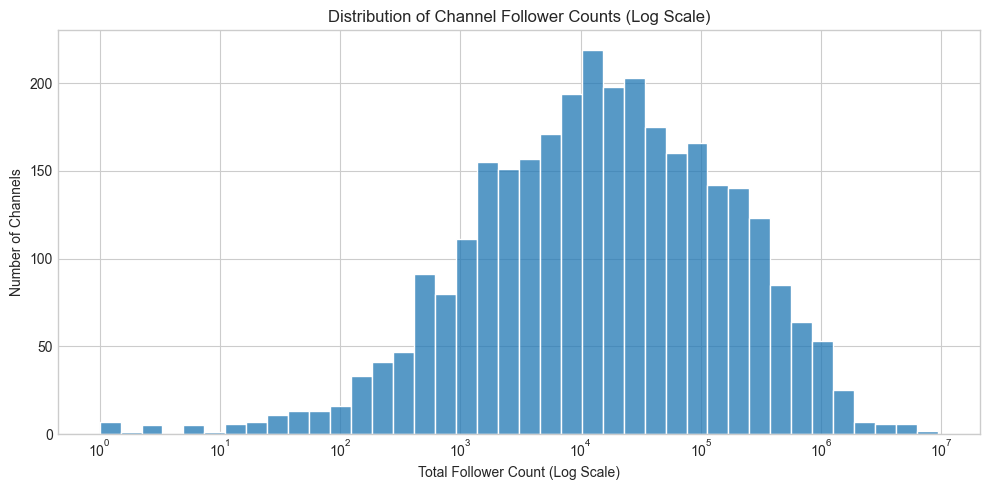

Generating Broadcaster Types Bar Chart...


C:\Users\User\AppData\Local\Temp\ipykernel_10412\3486324739.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=channel_types, order=channel_types.value_counts().index, palette='viridis');


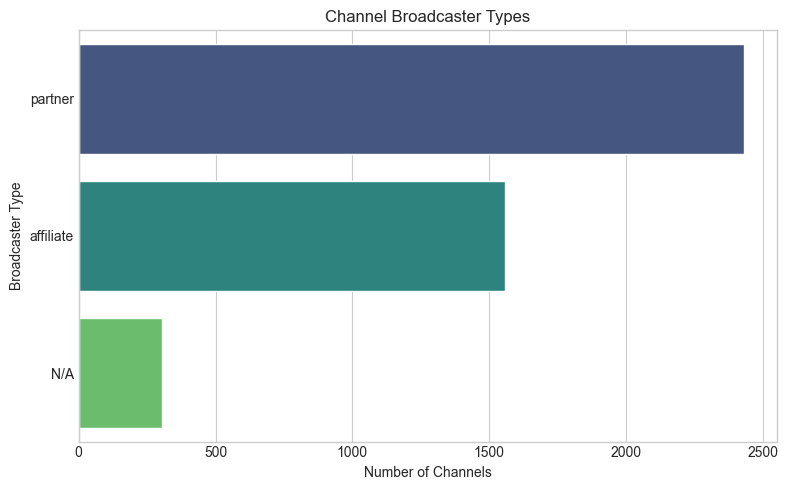

In [6]:
# Cell 10: Visualizations - Channels
print("\n--- Channel Visualizations ---")
plt.style.use('seaborn-v0_8-whitegrid')

# --- UPDATED: Histogram of Channel Follower Counts ---
print("Generating Channel Follower Count Histogram...")
plt.figure(figsize=(10, 5));
# Use the 'follower_count' column now, and drop any rows where it might be NaN
followers_positive = channels_df.dropna(subset=['follower_count'])
followers_positive = followers_positive[followers_positive['follower_count'] > 0]['follower_count']

if not followers_positive.empty:
    # Determine if log scale is needed by checking the data range
    should_use_log = (followers_positive.max() / followers_positive.min() > 100) if followers_positive.min() > 0 else False

    # Conditionally set the plotting arguments
    plot_kwargs = {'bins': 40, 'kde': False}
    if should_use_log:
        plot_kwargs['log_scale'] = True # Set to True, not a variable that could be False
        title = 'Distribution of Channel Follower Counts (Log Scale)'
        xlabel = 'Total Follower Count (Log Scale)'
    else:
        # Do not pass log_scale when it's not needed
        title = 'Distribution of Channel Follower Counts'
        xlabel = 'Total Follower Count'

    sns.histplot(followers_positive, **plot_kwargs)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Number of Channels')
    plt.tight_layout()
    plt.show()
else:
    print("No positive channel follower data to plot histogram yet.")

print("Generating Broadcaster Types Bar Chart...")
plt.figure(figsize=(8, 5));
channel_types = channels_df['broadcaster_type'].fillna('N/A').replace('', 'N/A')
sns.countplot(y=channel_types, order=channel_types.value_counts().index, palette='viridis');
plt.title('Channel Broadcaster Types')
plt.xlabel('Number of Channels')
plt.ylabel('Broadcaster Type')
plt.tight_layout()
plt.show()


--- Video Visualizations ---
Generating Video View Count Histogram...


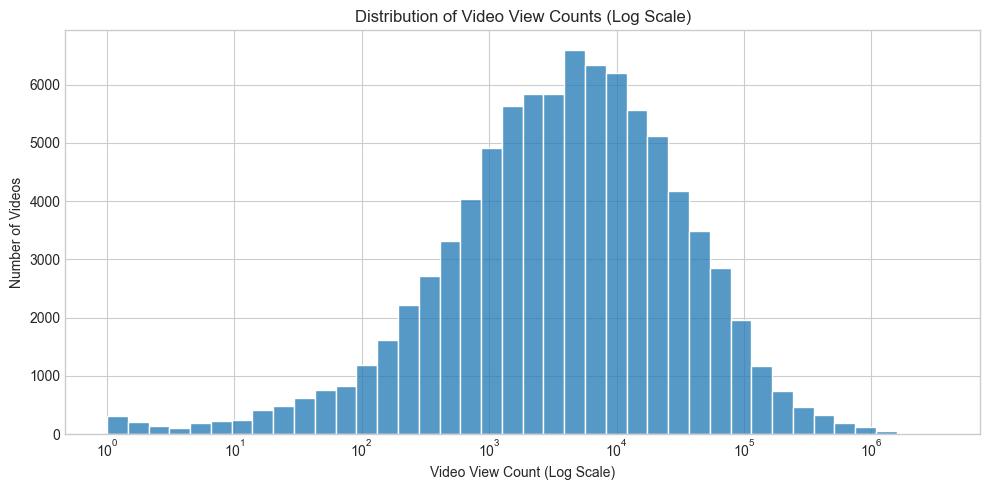

Generating Video Types Bar Chart...


C:\Users\User\AppData\Local\Temp\ipykernel_10412\2500711648.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=video_types, order=video_types.value_counts().index, palette='magma');


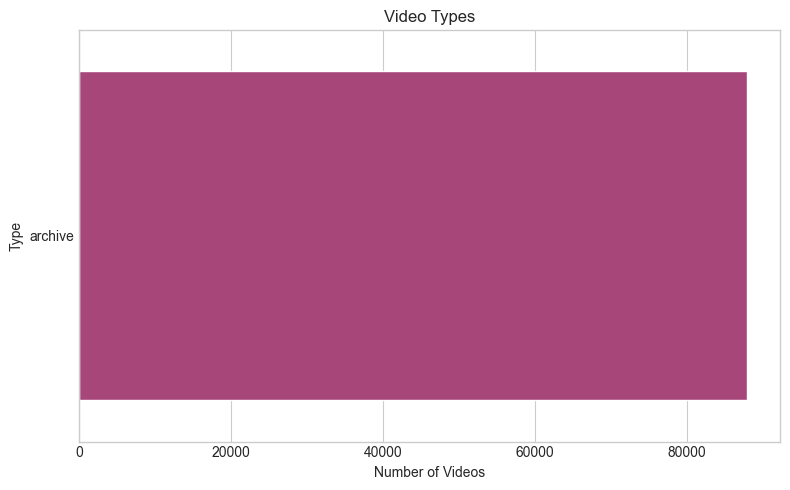

Generating Video Publication Time Series...
Displaying time series from 2025-04-20 onwards (showing 95% of the data).


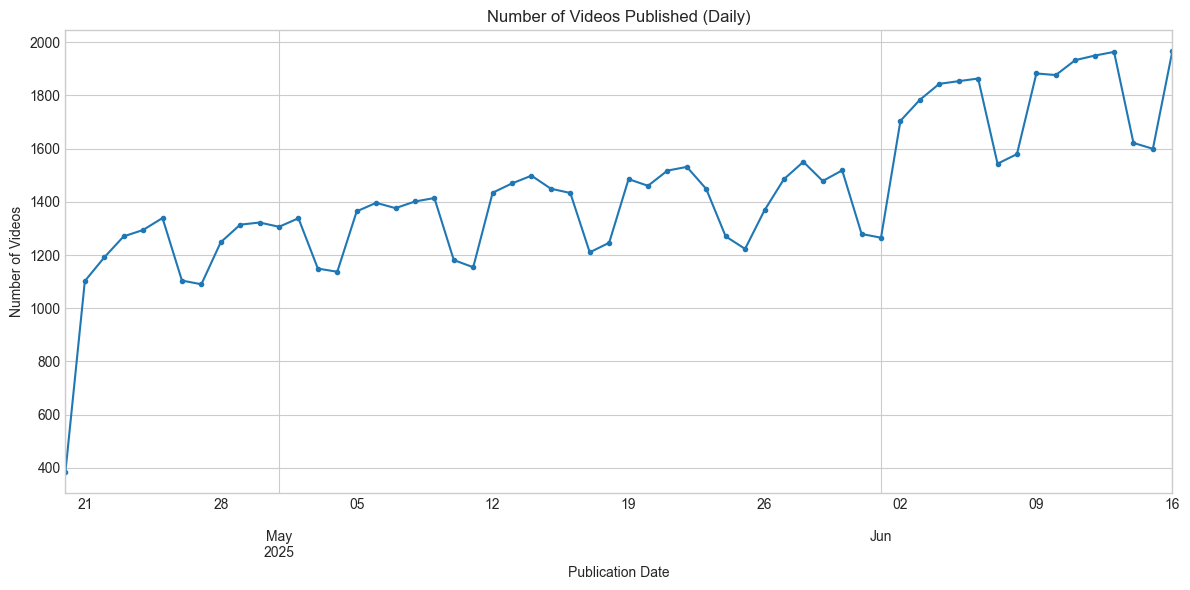

In [7]:
# Cell 11: Visualizations - Videos
print("\n--- Video Visualizations ---")

print("Generating Video View Count Histogram...")
plt.figure(figsize=(10, 5));
views_positive_vid = videos_df.dropna(subset=['view_count'])
views_positive_vid = views_positive_vid[views_positive_vid['view_count'] > 0]['view_count']

if not views_positive_vid.empty:
    # Determine if log scale is needed
    should_use_log_vid = (views_positive_vid.max() / views_positive_vid.min() > 100) if views_positive_vid.min() > 0 else False

    # Conditionally set the plotting arguments
    plot_kwargs_vid = {'bins': 40, 'kde': False}
    if should_use_log_vid:
        plot_kwargs_vid['log_scale'] = True
        title_vid = 'Distribution of Video View Counts (Log Scale)'
        xlabel_vid = 'Video View Count (Log Scale)'
    else:
        title_vid = 'Distribution of Video View Counts'
        xlabel_vid = 'Video View Count'

    sns.histplot(views_positive_vid, **plot_kwargs_vid)
    plt.title(title_vid)
    plt.xlabel(xlabel_vid)
    plt.ylabel('Number of Videos')
    plt.tight_layout()
    plt.show()
else:
    print("No positive video view data to plot histogram.")

print("Generating Video Types Bar Chart...")
plt.figure(figsize=(8, 5));
video_types = videos_df['type'].fillna('N/A');
sns.countplot(y=video_types, order=video_types.value_counts().index, palette='magma');
plt.title('Video Types');
plt.xlabel('Number of Videos');
plt.ylabel('Type');
plt.tight_layout();
plt.show()

# --- Video Publication Time Series ---
print("Generating Video Publication Time Series...")
plt.figure(figsize=(12, 6));
video_pub_dates = videos_df.dropna(subset=['published_at'])

if not video_pub_dates.empty and len(video_pub_dates) > 1:
    # --- Calculate the 5th percentile date to set the start range ---
    start_date = video_pub_dates['published_at'].quantile(0.05)
    print(f"Displaying time series from {start_date.strftime('%Y-%m-%d')} onwards (showing 95% of the data).")

    # Filter the DataFrame to this new date range
    plotting_df = video_pub_dates[video_pub_dates['published_at'] >= start_date]

    # --- Use the filtered plotting_df for the rest of the logic ---
    if not plotting_df.empty:
        time_range_days = (plotting_df['published_at'].max() - plotting_df['published_at'].min()).days if len(plotting_df) > 1 else 0
        resample_freq = 'ME' if time_range_days > 90 else 'D' # Resample by Month or Day
        plot_title = 'Number of Videos Published (' + ('Monthly' if resample_freq == 'ME' else 'Daily') + ')'

        # Plot the resampled data
        plotting_df.set_index('published_at')['id'].resample(resample_freq).count().plot(marker='.' if resample_freq == 'D' else 'o', linestyle='-');

        plt.title(plot_title);
        plt.ylabel('Number of Videos');
        plt.xlabel('Publication Date');
        plt.tight_layout();
        plt.show()
    else:
        print("No video data remains after filtering by start date.")
else:
    print("Not enough video publication date data to plot a meaningful time series.")

### Note on "Streaming Together" Feature

While Twitch has features like "Squad Streams" or "Guest Star" allowing multiple creators to stream simultaneously on one channel, the participant data for these features **does not appear to be reliably available** via the standard Twitch API for *past* streams or VODs (as of June 2025).

Therefore, the collaboration detection in this notebook relies primarily on identifying `@mentions` within video titles and descriptions.


# Collaboration Network Exploration (Filtered)

Exploring the collaboration network. Data is filtered IN MEMORY based on
thresholds in `config.py` BEFORE analysis to improve performance.
The underlying database remains complete.


In [8]:
# Cell 12: Load and Filter Data for Network Analysis
print(f"\n--- Loading and Filtering Data for Network Analysis at {datetime.now().strftime('%H:%M:%S')} ---")
channels_df_net = pd.DataFrame()  # For channels passing all filters
collab_df_net = pd.DataFrame()   # For edges passing all filters
G_filtered = nx.Graph()          # The filtered graph for analysis
degree_df_filtered = pd.DataFrame() # For degree stats

try:
    # --- 1. Load base data ---
    collab_df_full = pd.read_sql_query("SELECT * FROM Collaborations", db_conn)
    collab_df_full['collaboration_count'] = pd.to_numeric(collab_df_full['collaboration_count'], errors='coerce').fillna(0).astype(int)
    collab_df_full['total_collaboration_duration_seconds'] = pd.to_numeric(collab_df_full['total_collaboration_duration_seconds'], errors='coerce').fillna(0).astype(int)


    # --- 2. Filter Channels ---
    print(f"Filtering channels by follower count (>= {config.NETWORK_MIN_FOLLOWER_COUNT})...")
    channels_df_filtered_fc = channels_df[channels_df['follower_count'] >= config.NETWORK_MIN_FOLLOWER_COUNT]
    print(f" -> Channels after follower count filter: {len(channels_df_filtered_fc)}")

    if not videos_df.empty:
        print(f"Filtering channels by video count (>= {config.NETWORK_MIN_CHANNEL_VIDEO_COUNT})...")
        video_counts_per_channel = videos_df['channel_id'].value_counts()
        channels_with_enough_videos = video_counts_per_channel[video_counts_per_channel >= config.NETWORK_MIN_CHANNEL_VIDEO_COUNT].index.tolist()
        channels_df_net = channels_df_filtered_fc[channels_df_filtered_fc['id'].isin(channels_with_enough_videos)]
        print(f" -> Channels after video count filter: {len(channels_df_net)}")
    else:
        print("Warning: videos_df not available for filtering by video count. Using only follower count filter for channels.")
        channels_df_net = channels_df_filtered_fc

    valid_channel_ids_for_network = set(channels_df_net['id'])
    print(f"Total channels passing node filters: {len(valid_channel_ids_for_network)}")

    # --- 3. Filter Collaborations (Edges) ---
    if not collab_df_full.empty:
        print(f"Filtering collaboration edges by count (>= {config.NETWORK_MIN_COLLABORATION_COUNT})...")
        collab_df_filtered_count = collab_df_full[collab_df_full['collaboration_count'] >= config.NETWORK_MIN_COLLABORATION_COUNT]
        print(f" -> Edges after count filter: {len(collab_df_filtered_count)}")

        print("Filtering edges to ensure both connected channels passed node filters...")
        collab_df_net = collab_df_filtered_count[
            collab_df_filtered_count['channel_id_1'].isin(valid_channel_ids_for_network) &
            collab_df_filtered_count['channel_id_2'].isin(valid_channel_ids_for_network)
        ].copy() # Use .copy() to avoid SettingWithCopyWarning
        print(f" -> Edges after node validity filter: {len(collab_df_net)}")

        # --- Cap outlier durations before creating graph ---
        duration_threshold_weeks = config.NETWORK_DURATION_OUTLIER_WEEKS
        duration_threshold_seconds = duration_threshold_weeks * 7 * 24 * 3600

        outlier_edges = collab_df_net['total_collaboration_duration_seconds'] > duration_threshold_seconds
        outlier_count = outlier_edges.sum()

        if outlier_count > 0:
            # The f-string now uses the config variable directly for accurate reporting
            print(f"Capping duration for {outlier_count} edge(s) with duration > {duration_threshold_weeks} week(s) for network analysis.")

            # Use .loc to safely modify the DataFrame
            collab_df_net.loc[outlier_edges, 'total_collaboration_duration_seconds'] = duration_threshold_seconds

    else:
        print("Full collaboration data (collab_df_full) is empty. Filtered collaboration data will be empty.")
        collab_df_net = pd.DataFrame()

    # --- 4. Create Filtered NetworkX Graph ---
    if not collab_df_net.empty:
        print("Creating NetworkX graph G_filtered from filtered data...")
        G_filtered = nx.from_pandas_edgelist(
            collab_df_net,
            'channel_id_1',
            'channel_id_2',
            edge_attr=['collaboration_count', 'total_collaboration_duration_seconds', 'latest_collaboration_timestamp']
        )
        G_filtered.add_nodes_from(valid_channel_ids_for_network)
        print(f"Filtered graph G_filtered created with {G_filtered.number_of_nodes()} nodes and {G_filtered.number_of_edges()} edges.")
    else:
        print("No edges passed all filters. Filtered graph G_filtered will be empty or contain only isolated nodes.")
        if valid_channel_ids_for_network: G_filtered.add_nodes_from(valid_channel_ids_for_network)
        print(f"Filtered graph G_filtered has {G_filtered.number_of_nodes()} nodes and {G_filtered.number_of_edges()} edges.")

except Exception as e:
    print(f"Error loading or filtering data for network analysis: {e}")
    logging.error("Error in network data prep:", exc_info=True)
    if 'G_filtered' not in locals(): G_filtered = nx.Graph()

print("--- Network Data Preparation Complete ---")


--- Loading and Filtering Data for Network Analysis at 12:35:32 ---
Filtering channels by follower count (>= 1000)...
 -> Channels after follower count filter: 2691
Filtering channels by video count (>= 5)...
 -> Channels after video count filter: 2224
Total channels passing node filters: 2224
Filtering collaboration edges by count (>= 2)...
 -> Edges after count filter: 1290
Filtering edges to ensure both connected channels passed node filters...
 -> Edges after node validity filter: 595
Capping duration for 15 edge(s) with duration > 1 week(s) for network analysis.
Creating NetworkX graph G_filtered from filtered data...
Filtered graph G_filtered created with 2224 nodes and 595 edges.
--- Network Data Preparation Complete ---


In [9]:
# Cell 13: Display Sample Filtered Collaboration Data
print("\nSample Filtered Collaboration Edges (collab_df_net):")
if not collab_df_net.empty:
    display(collab_df_net.head())
else:
    print("No collaboration data in collab_df_net (all edges filtered out or none exist).")



Sample Filtered Collaboration Edges (collab_df_net):


,channel_id_1,channel_id_2,collaboration_count,total_collaboration_duration_seconds,latest_collaboration_timestamp,first_collaboration_timestamp,last_updated
4,63667409,77964394,2,25725,2025-06-02 12:05:34+00:00,2025-06-02 12:05:34+00:00,2025-06-16 12:59:25.390502+00:00
8,149682636,274440537,2,18793,2025-06-03 09:01:48+00:00,2025-06-03 09:01:48+00:00,2025-06-16 13:11:27.200239+00:00
11,181357564,92062529,9,243194,2025-06-02 11:27:14+00:00,2025-06-02 11:27:14+00:00,2025-06-16 14:21:13.711133+00:00
12,85397463,92062529,15,527796,2025-05-31 08:34:09+00:00,2025-05-22 08:52:40+00:00,2025-06-16 13:11:15.932426+00:00
21,525258443,52668922,4,115431,2025-05-25 04:36:39+00:00,2025-05-25 04:36:39+00:00,2025-06-16 14:21:16.157785+00:00


In [10]:
# Cell 14: Filtered Collaboration Network Statistics
if 'G_filtered' in locals() and G_filtered.number_of_nodes() > 0:
    print("\n--- Filtered Collaboration Network Statistics ---")
    print(f"Total Edges in Filtered Network: {G_filtered.number_of_edges()}")
    print(f"Total Nodes in Filtered Network: {G_filtered.number_of_nodes()}")

    if G_filtered.number_of_nodes() > 0:
        degree_sequence = [d for n, d in G_filtered.degree()]
        degree_df_filtered = pd.DataFrame({'channel_id': list(G_filtered.nodes()), 'degree': degree_sequence})

        print("\nDegree Distribution Summary (Filtered Network):")
        print(degree_df_filtered['degree'].describe())

        # Merge with channel names for context
        channels_for_labels_df = channels_df[['id', 'login', 'display_name']].rename(columns={'id': 'channel_id'})
        degree_df_filtered = pd.merge(degree_df_filtered, channels_for_labels_df, on='channel_id', how='left')

        print("\nTop 10 Channels by Degree (Filtered Network):")
        print(degree_df_filtered.nlargest(10, 'degree'))
    else:
        print("Filtered graph has no nodes to calculate degree.")

    # Summary for edges in collab_df_net
    if not collab_df_net.empty:
        print("\nCollaboration Count per Edge Summary (Filtered Network):")
        print(collab_df_net['collaboration_count'].describe())

        # --- Human-Readable Duration Summary ---
        print("\nTotal Collaboration Duration per Edge Summary (Filtered Network):")
        duration_stats = collab_df_net['total_collaboration_duration_seconds'].describe()

        # Create and print a formatted summary
        formatted_stats = {
            'count': f"{duration_stats['count']:.0f}",
            'mean': format_seconds_to_hm(duration_stats['mean']),
            'std dev': f"~{format_seconds_to_hm(duration_stats['std'])}",
            'min': format_seconds_to_hm(duration_stats['min']),
            '25%': format_seconds_to_hm(duration_stats['25%']),
            '50% (median)': format_seconds_to_hm(duration_stats['50%']),
            '75%': format_seconds_to_hm(duration_stats['75%']),
            'max': format_seconds_to_hm(duration_stats['max'])
        }

        for key, value in formatted_stats.items():
            # Left-align the key, right-align the value for clean output
            print(f"{key:<15} {value:>15}")

    else:
        print("No edges in collab_df_net to summarize.")
else:
    print("\nFiltered graph G_filtered is empty. No statistics to display.")


--- Filtered Collaboration Network Statistics ---
Total Edges in Filtered Network: 595
Total Nodes in Filtered Network: 2224

Degree Distribution Summary (Filtered Network):
count    2224.000000
mean        0.535072
std         1.138866
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        14.000000
Name: degree, dtype: float64

Top 10 Channels by Degree (Filtered Network):
    channel_id  degree            login     display_name
467   16064695      14        dhalucard        Dhalucard
315  103700930      10           zoodle           Zoodle
50    10817445       9           itmejp           itmeJP
65    66628850       9            arrav            Arrav
76    43494917       9             knut             Knut
328  204505974       8          vangard          Vangard
77    91067577       7            emiru            Emiru
317   71610909       7  nuclearpastatom  NuclearPastaTom
320   30258310       7         mitchriz         Mitchriz
324   43204


--- Filtered Collaboration Network Visualizations ---
Generating Degree Distribution Histogram for the filtered network...


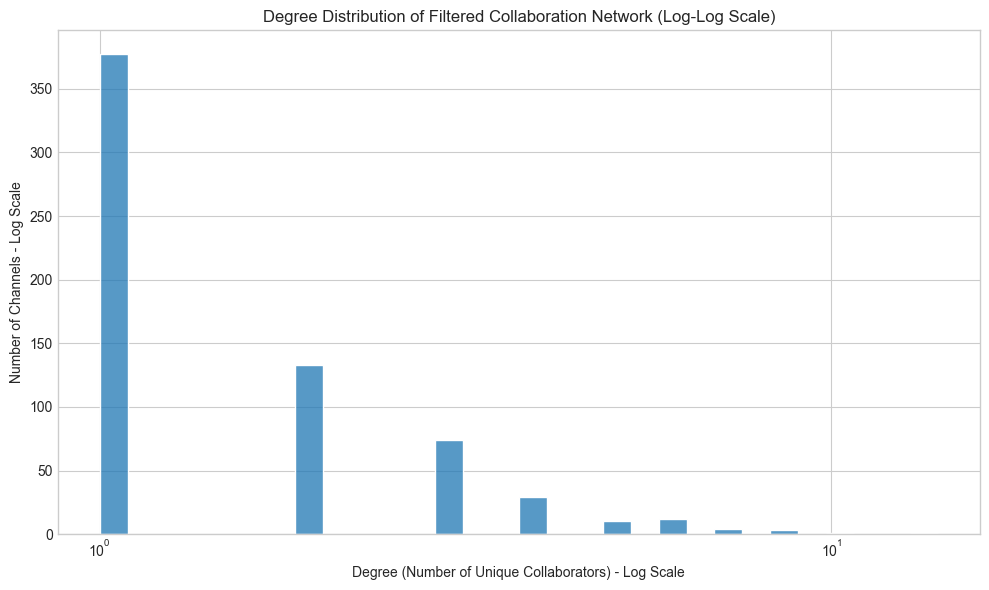

2025-06-17 12:36:25,091 - INFO - category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\User\AppData\Local\Temp\ipykernel_10412\893932636.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=collab_counts_filtered, palette='viridis', order = sorted(collab_counts_filtered.unique()))
2025-06-17 12:36:25,097 - INFO - category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



Generating Edge Weight (Collaboration Count) Plot...


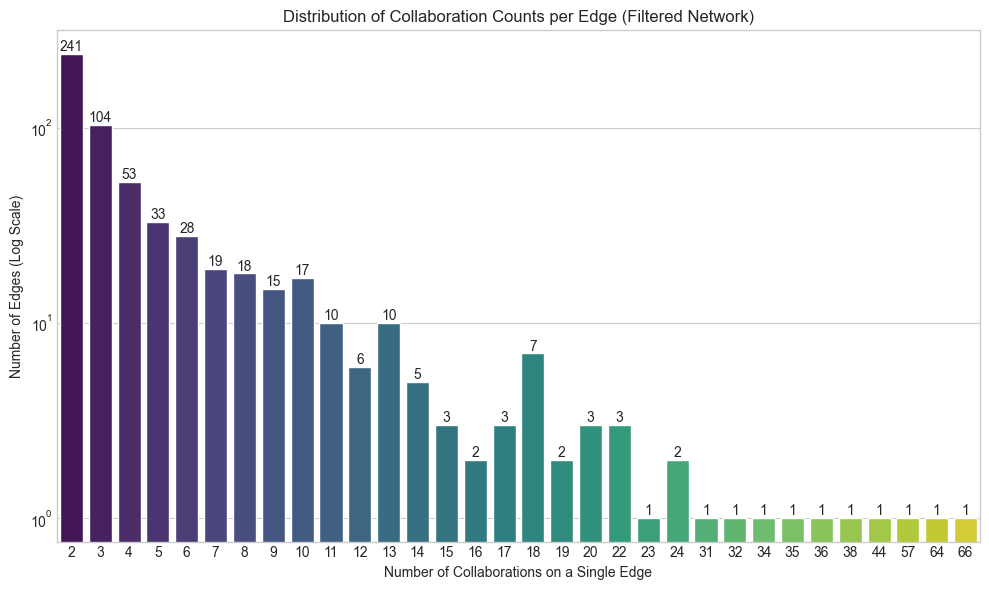

In [11]:
# Cell 15: Filtered Collaboration Network Visualizations
if 'G_filtered' in locals() and G_filtered.number_of_nodes() > 0 and 'degree_df_filtered' in locals() and not degree_df_filtered.empty:
    print("\n--- Filtered Collaboration Network Visualizations ---")

    # --- 1. Degree Distribution Histogram ---
    print("Generating Degree Distribution Histogram for the filtered network...")
    plt.figure(figsize=(10, 6))

    degrees_filtered = degree_df_filtered[degree_df_filtered['degree'] > 0]['degree']
    if not degrees_filtered.empty:
        # Log-log scale is common for degree distributions to check for power-law behavior
        sns.histplot(degrees_filtered, log_scale=True, bins=30)
        plt.title('Degree Distribution of Filtered Collaboration Network (Log-Log Scale)')
        plt.xlabel('Degree (Number of Unique Collaborators) - Log Scale')
        plt.ylabel('Number of Channels - Log Scale')
        plt.tight_layout()
        plt.show()
    else:
        print("No nodes with degree > 0 found to plot.")

    # --- 2. Edge Weight (Collaboration Count) Plot ---
    if not collab_df_net.empty:
        print("\nGenerating Edge Weight (Collaboration Count) Plot...")
        plt.figure(figsize=(10, 6))

        collab_counts_filtered = collab_df_net[collab_df_net['collaboration_count'] > 0]['collaboration_count']

        if not collab_counts_filtered.empty:
            # A countplot is more direct and robust for this type of discrete integer data
            ax = sns.countplot(x=collab_counts_filtered, palette='viridis', order = sorted(collab_counts_filtered.unique()))

            # Add text labels on top of each bar
            for p in ax.patches:
                ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', xytext=(0, 5), textcoords='offset points')

            plt.title('Distribution of Collaboration Counts per Edge (Filtered Network)')
            plt.xlabel('Number of Collaborations on a Single Edge')

            # Conditionally apply log scale to y-axis only if counts are high
            max_count = collab_counts_filtered.value_counts().max()
            if max_count > 10:
                plt.yscale('log')
                plt.ylabel('Number of Edges (Log Scale)')
            else:
                plt.ylabel('Number of Edges (Linear Scale)')

            plt.tight_layout()
            plt.show()
        else:
            print("No collaborations with count > 0 found to plot.")

else:
    print("\nFiltered graph or degree data insufficient for visualization. Skipping.")

## Community Detection in Collaboration Network

In [12]:
# Cell 16: Community Detection Setup and Execution
import community as community_louvain  # python-louvain library

communities_detected = False
partition = {}
communities = {}

if 'G_filtered' in locals() and G_filtered.number_of_nodes() > 0:
    print(
        f"\n--- Performing Louvain Community Detection on FILTERED graph at {datetime.now().strftime('%H:%M:%S')} ---")
    print(f"Using 'collaboration_count' as edge weight for community detection.")

    for u, v, data in G_filtered.edges(data=True):
        if 'weight' not in data:
            G_filtered.edges[u, v]['weight'] = data.get('collaboration_count', 1)

    start_time_community = time.time()
    try:
        partition = community_louvain.best_partition(G_filtered, weight='weight', random_state=42)
        modularity = community_louvain.modularity(partition, G_filtered, weight='weight')

        for node, community_id in partition.items():
            if community_id not in communities: communities[community_id] = []
            communities[community_id].append(node)

        num_communities = len(communities)
        print(f"Louvain Community Detection complete in {time.time() - start_time_community:.2f}s.")
        print(f"Found {num_communities} communities.")
        print(f"Modularity of the partition: {modularity:.4f}")

        sorted_communities_by_size = sorted(communities.items(), key=lambda item: len(item[1]), reverse=True)
        print("\nTop 5 Largest Communities:")
        for i in range(min(5, len(sorted_communities_by_size))):
            cid, nodes = sorted_communities_by_size[i]
            member_names = [
                channels_for_labels_df.loc[channels_for_labels_df['channel_id'] == node_id, 'login'].iloc[0]
                for node_id in nodes[:3]
                if not channels_for_labels_df[channels_for_labels_df['channel_id'] == node_id].empty
            ]
            print(
                f"  Community {cid} (Size rank {i + 1}): {len(nodes)} members. Examples: {', '.join(member_names[:3])}...")
        communities_detected = True
    except Exception as e:
        print(f"Error during community detection: {e}")
else:
    print("\nFiltered graph G_filtered not found or is empty. Skipping community detection.")



--- Performing Louvain Community Detection on FILTERED graph at 12:36:27 ---
Using 'collaboration_count' as edge weight for community detection.
Louvain Community Detection complete in 0.09s.
Found 1752 communities.
Modularity of the partition: 0.9683

Top 5 Largest Communities:
  Community 54 (Size rank 1): 39 members. Examples: tolkin, karni, noway4u_sir...
  Community 16 (Size rank 2): 23 members. Examples: knirpz, ronnyberger, junicats...
  Community 26 (Size rank 3): 19 members. Examples: distortion2, boosfer, wolfeei...
  Community 17 (Size rank 4): 15 members. Examples: jinnytty, arrav, crazyjapanese...
  Community 22 (Size rank 5): 14 members. Examples: chowh1, punkill, yugokaa...


### Visualizing Communities


--- NetworkX Subgraph Visualization with Community Colors (on Filtered Graph) ---
Creating subgraph visualization with 40 nodes and 44 edges, colored by community.


C:\Users\User\AppData\Local\Temp\ipykernel_10412\3253915883.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20',


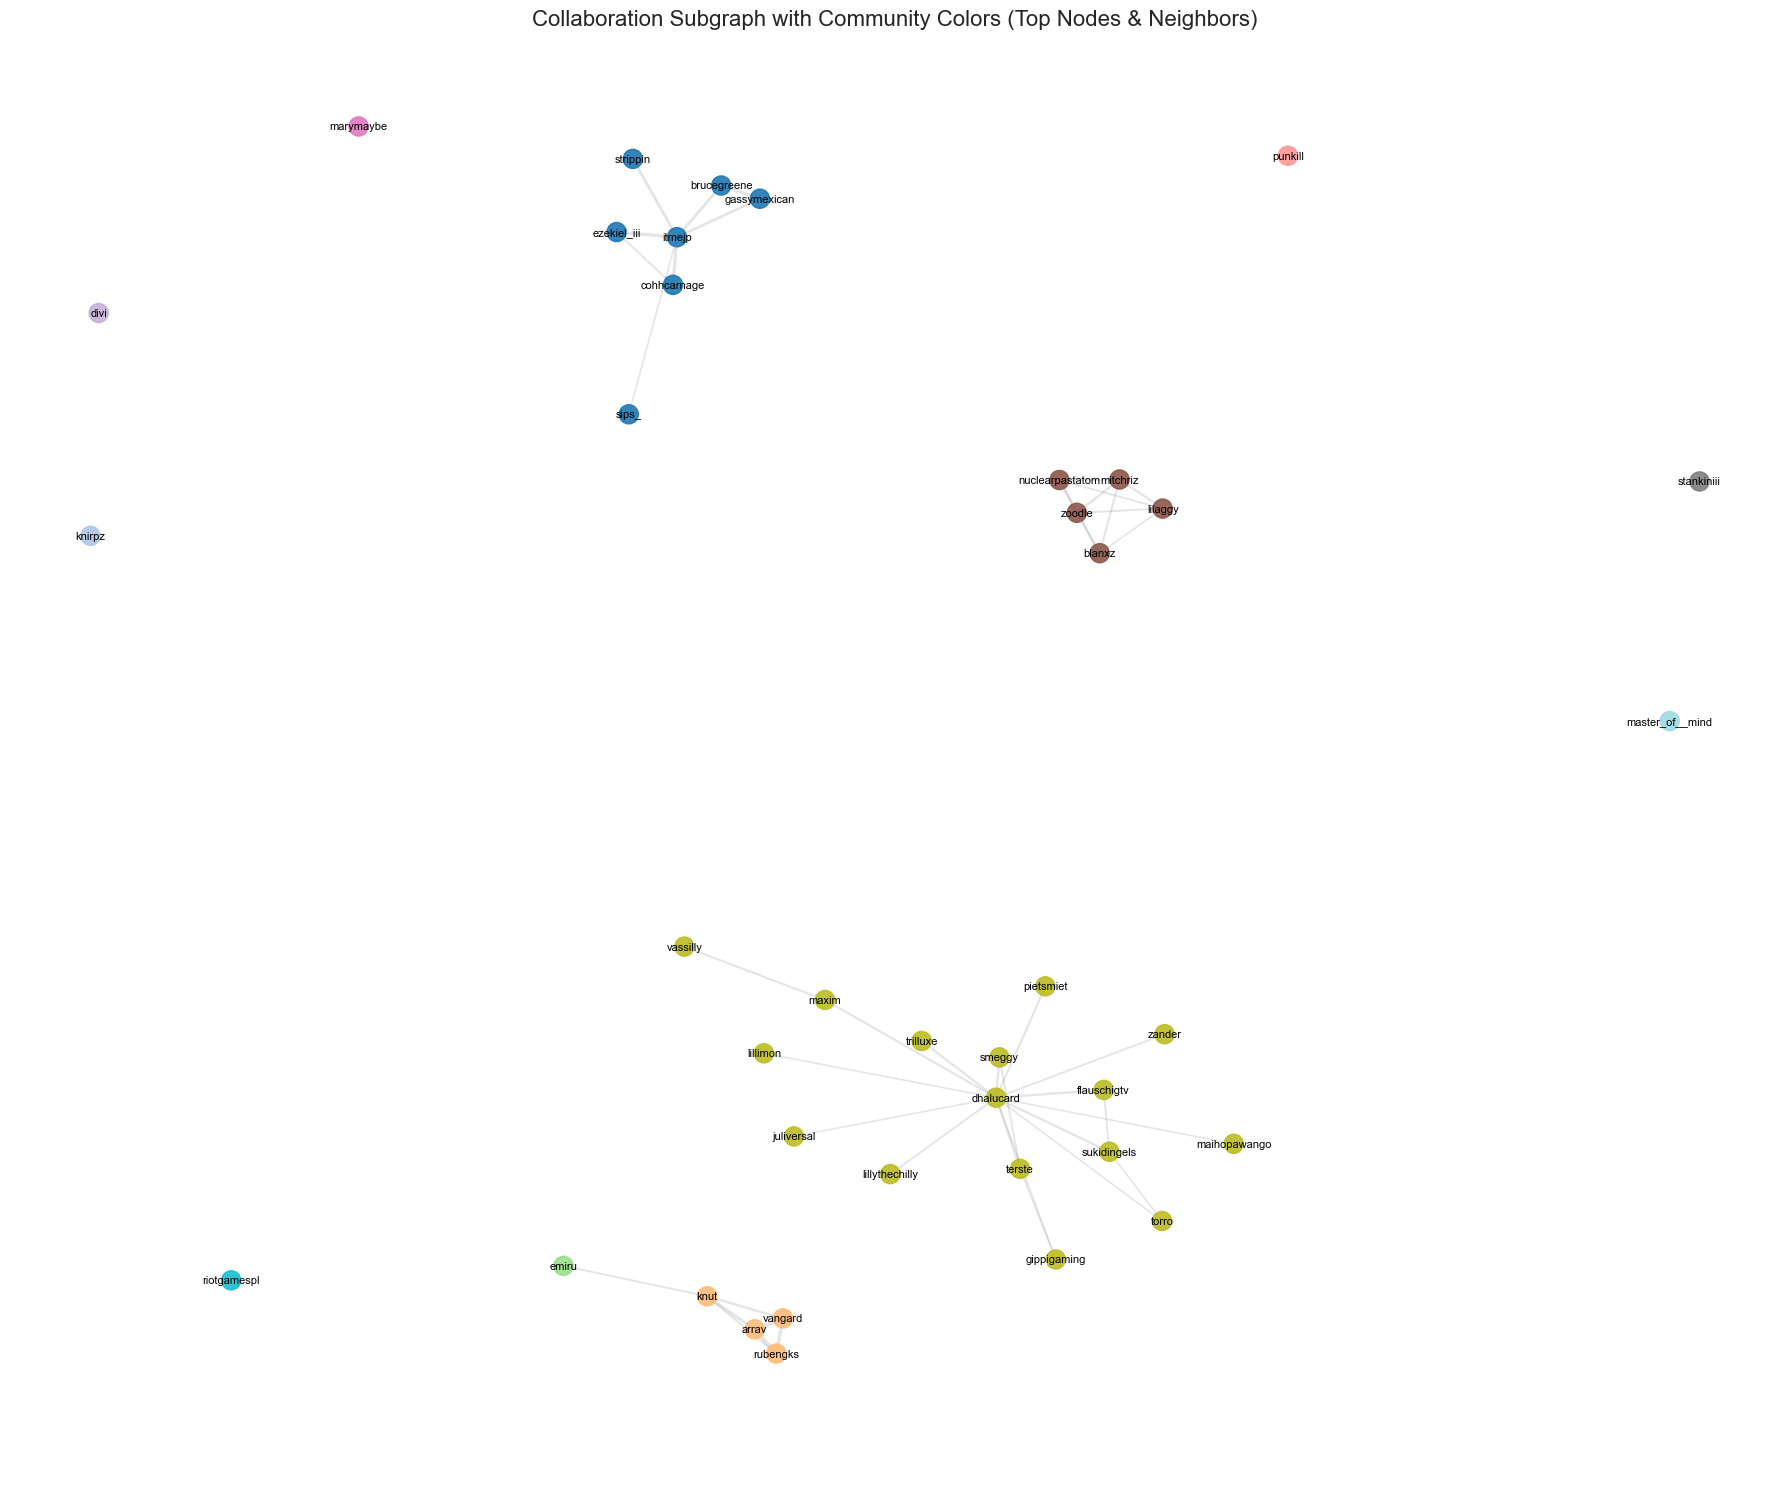

In [13]:
# Cell 17: Visualize Subgraph with Community Colors
if communities_detected and 'G_filtered' in locals() and G_filtered.number_of_nodes() > 0:
    print("\n--- NetworkX Subgraph Visualization with Community Colors (on Filtered Graph) ---")
    try:
        top_nodes_filtered = degree_df_filtered.nlargest(config.NETWORK_VIZ_TOP_N_CHANNELS_BY_DEGREE, 'degree')[
            'channel_id'].tolist()
        subgraph_nodes_set = set(top_nodes_filtered)
        max_subgraph_nodes = config.NETWORK_VIZ_MAX_SUBGRAPH_NODES

        for node in list(subgraph_nodes_set):
            if G_filtered.has_node(node) and len(subgraph_nodes_set) < max_subgraph_nodes:
                neighbors = list(G_filtered.neighbors(node))
                needed = max_subgraph_nodes - len(subgraph_nodes_set)
                subgraph_nodes_set.update(neighbors[:needed])

        subgraph = G_filtered.subgraph(list(subgraph_nodes_set))
        print(
            f"Creating subgraph visualization with {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges, colored by community.")

        if subgraph.number_of_nodes() > 0:
            unique_community_ids_in_subgraph = sorted(
                list(set(partition[node] for node in subgraph.nodes() if node in partition)))
            community_to_color_idx = {comm_id: i for i, comm_id in enumerate(unique_community_ids_in_subgraph)}
            num_distinct_colors_needed = len(unique_community_ids_in_subgraph)

            node_colors_subgraph = 'grey'
            if num_distinct_colors_needed > 0:
                cmap = plt.cm.get_cmap('tab20',
                                       num_distinct_colors_needed) if num_distinct_colors_needed <= 20 else plt.cm.get_cmap(
                    'viridis', num_distinct_colors_needed)
                node_colors_subgraph = [cmap(community_to_color_idx[partition[node]]) for node in subgraph.nodes() if
                                        node in partition]

            node_data_subgraph = channels_df[channels_df['id'].isin(subgraph.nodes())].set_index('id')
            subgraph_node_sizes = [math.log10(
                max(1, node_data_subgraph.loc[
                    node, 'view_count'] if node in node_data_subgraph.index else 1) + 1) * 300 + 100
                                   for node in subgraph.nodes()]
            node_labels_subgraph = pd.merge(pd.DataFrame({'channel_id': list(subgraph.nodes())}),
                                            channels_for_labels_df, on='channel_id', how='left').set_index(
                'channel_id')['login'].to_dict()
            edge_widths_subgraph = [math.log10(max(0, d.get('weight', 0)) + 1) * 1.5 + 0.5 for u, v, d in
                                    subgraph.edges(data=True)]

            plt.figure(figsize=(18, 15));
            pos_subgraph = nx.spring_layout(subgraph, k=0.4, iterations=50, seed=42)
            nx.draw_networkx_nodes(subgraph, pos_subgraph, node_size=subgraph_node_sizes,
                                   node_color=node_colors_subgraph, alpha=0.9)
            nx.draw_networkx_edges(subgraph, pos_subgraph, width=edge_widths_subgraph, alpha=0.2, edge_color='gray')
            nx.draw_networkx_labels(subgraph, pos_subgraph, labels=node_labels_subgraph, font_size=8)
            plt.title(f'Collaboration Subgraph with Community Colors (Top Nodes & Neighbors)', fontsize=16);
            plt.axis('off');
            plt.tight_layout();
            plt.show()
        else:
            print("Subgraph is empty, cannot visualize communities.")
    except ImportError:
        print("\n`python-louvain` (community) library not found. Skipping community detection visualization.")
    except Exception as e:
        print(f"Error during community visualization: {e}");
        logging.error("Community visualization error",
                      exc_info=True)
else:
    print("\nNo communities detected or filtered graph is empty. Skipping community visualization.")


## Collaboration Context Exploration (by Game Category)
This section analyzes the breakdown of collaborations by the game category they occurred in.

In [14]:
# Cell 18: Load Collaboration Context Data
print("\nLoading collaboration context data...")
try:
    collab_context_df = pd.read_sql_query("SELECT * FROM CollaborationContext", db_conn)
    collab_context_df['context_collaboration_count'] = pd.to_numeric(collab_context_df['context_collaboration_count'],
                                                                     errors='coerce').fillna(0).astype(int)
    collab_context_df['context_total_duration_seconds'] = pd.to_numeric(
        collab_context_df['context_total_duration_seconds'], errors='coerce').fillna(0).astype(int)
    if 'last_updated' in collab_context_df.columns:
        collab_context_df['last_updated'] = pd.to_datetime(collab_context_df['last_updated'], errors='coerce', utc=True)
    print(f"Loaded {len(collab_context_df)} collaboration context records.")
except Exception as e:
    print(f"Error loading collaboration context data: {e}")
    collab_context_df = pd.DataFrame()



Loading collaboration context data...
Loaded 3057 collaboration context records.


In [16]:
# Cell 19: Explore Collaboration Context
if not collab_context_df.empty and 'collab_df_full' in locals() and not collab_df_full.empty:
    print("\n--- Collaboration Context Analysis ---")

    # 1. Find all pairs that have collaborated in at least one known game category
    pairs_with_known_context = collab_context_df[
        (collab_context_df['game_id'] != 'UNKNOWN_GAME_ID') & (collab_context_df['game_id'].notna())
    ][['channel_id_1', 'channel_id_2']].drop_duplicates()

    if not pairs_with_known_context.empty:
        # 2. Get the total collaboration counts for these "interesting" pairs and find the top N
        top_interesting_pairs = pd.merge(
            pairs_with_known_context,
            collab_df_full,
            on=['channel_id_1', 'channel_id_2'],
            how='inner' # Use inner merge to keep only pairs present in both lists
        )

        top_n_to_display = 3
        top_pairs_to_show = top_interesting_pairs.nlargest(top_n_to_display, 'collaboration_count')

        print(f"Displaying collaboration context breakdown for top {len(top_pairs_to_show)} collaborating pairs (who have at least one known game context).")

        # 3. Loop through the top pairs and generate analysis for each
        for _, pair_row in top_pairs_to_show.iterrows():
            ch1_id, ch2_id = pair_row['channel_id_1'], pair_row['channel_id_2']

            # Get channel names for display
            ch1_name_row = channels_df[channels_df['id'] == ch1_id]
            ch2_name_row = channels_df[channels_df['id'] == ch2_id]
            ch1_name = ch1_name_row['login'].iloc[0] if not ch1_name_row.empty else ch1_id
            ch2_name = ch2_name_row['login'].iloc[0] if not ch2_name_row.empty else ch2_id

            print(f"\n\n" + "="*50)
            print(f"--- Analyzing Context: {ch1_name} <==> {ch2_name} ---")
            print(f"Total Collaborations: {pair_row['collaboration_count']}")
            print("="*50)


            # Filter context data for this specific pair
            pair_context = collab_context_df[
                (collab_context_df['channel_id_1'] == ch1_id) &
                (collab_context_df['channel_id_2'] == ch2_id)
            ].copy()

            if not pair_context.empty:
                # Calculate proportions based on count
                total_collabs_in_pair = pair_context['context_collaboration_count'].sum()
                if total_collabs_in_pair > 0:
                    pair_context['proportion_by_count'] = pair_context['context_collaboration_count'] / total_collabs_in_pair * 100
                else:
                    pair_context['proportion_by_count'] = 0

                # Sort and select top N categories + an 'Other' category for the pie chart
                pair_context.sort_values('proportion_by_count', ascending=False, inplace=True)
                top_n_cats = 7
                if len(pair_context) > top_n_cats:
                    other_sum_prop = pair_context.iloc[top_n_cats:]['proportion_by_count'].sum()
                    other_sum_count = pair_context.iloc[top_n_cats:]['context_collaboration_count'].sum()
                    other_row = pd.DataFrame([{'game_name': 'Other Categories', 'proportion_by_count': other_sum_prop, 'context_collaboration_count': other_sum_count}])
                    pair_context_display = pd.concat([pair_context.iloc[:top_n_cats], other_row], ignore_index=True)
                else:
                    pair_context_display = pair_context

                print("\nCollaboration Context Breakdown (Proportion by Count):")
                display(pair_context_display[['game_name', 'context_collaboration_count', 'proportion_by_count']].round(1).reset_index(drop=True))

                # Create a Bar Chart (often clearer than a pie chart for many categories)
                plt.figure(figsize=(10, 6))
                sns.barplot(x='proportion_by_count', y='game_name', data=pair_context_display, palette='crest_r', order=pair_context_display.sort_values('proportion_by_count', ascending=False)['game_name'])
                plt.title(f'Collaboration Context by Game Category\n({ch1_name} & {ch2_name})', fontsize=14)
                plt.xlabel('Proportion of Collaborations (%)')
                plt.ylabel('Game Category')
                plt.tight_layout()
                plt.show()

            else:
                print(f"No specific context data found for the collaboration between {ch1_name} and {ch2_name}.")

    else:
        print("No collaborations with a known game context found to analyze.")
else:
    print("Collaboration or Context data is empty, skipping context analysis.")


--- Collaboration Context Analysis ---
No collaborations with a known game context found to analyze.


# Interactive Collaboration Network Snippet (Searchable)

Type part of a channel name (login or display name) and click "Search & Visualize" to see its immediate collaboration network.

- If multiple channels match your search, select the specific one from the second dropdown.
- Node size is proportional to the channel's total follower count (log scale).
- Edge thickness is proportional to the number of collaboration instances found (log scale).
- Edge labels show the most frequent game category for the collaboration and its percentage.

*(Note: Embedding channel profile pictures directly within nodes is complex with this plotting method and is omitted.)*

In [22]:
# Cell 20: Setup for Searchable Interactive Visualization
print(f"\n--- Setting up Interactive Channel Network Visualization at {datetime.now().strftime('%H:%M:%S')} ---")
# Widgets
search_input = Text(description="Channel Name:", placeholder="Enter login or display name (min 3 chars)",
                    style={'description_width': 'initial'})
search_button = Button(description="Search & Visualize", button_style='info',
                       tooltip='Search for the channel and display its network')
results_dropdown = Dropdown(description="Select Match:", options=[("---", None)], disabled=True,
                            style={'description_width': 'initial'}, layout={'width': 'max-content'})
message_output = Output(layout={'margin': '10px 0 0 0'})
plot_output = Output()




--- Setting up Interactive Channel Network Visualization at 13:17:10 ---


In [23]:
# Cell 21: Visualization Function for Interactive Widget
def visualize_channel_neighborhood(selected_channel_id):
    """Queries data and draws the network neighborhood for the selected channel ID."""
    with plot_output:
        plot_output.clear_output(wait=True);
        with message_output: message_output.clear_output()
        if not selected_channel_id: return

        selected_channel_row = channels_df[channels_df['id'] == selected_channel_id]
        if selected_channel_row.empty: print(f"Selected channel ID {selected_channel_id} not found."); return
        selected_channel_name_for_title = selected_channel_row['display_name'].iloc[0]

        print(f"Generating visualization for: {selected_channel_name_for_title} ({selected_channel_id})...")
        edges = collab_df_full[(collab_df_full['channel_id_1'] == selected_channel_id) | (collab_df_full['channel_id_2'] == selected_channel_id)].copy()

        if edges.empty:
            print(f"No collaboration data found in the database for channel: {selected_channel_name_for_title}")
            G = nx.Graph(); G.add_node(selected_channel_id)
            node_data = selected_channel_row.set_index('id')
            # Use follower_count, with a fallback to a small number
            follower_count = max(1, node_data.loc[selected_channel_id].get('follower_count', 1))
            node_size = math.log10(follower_count + 1) * 200 + 150
            node_label = {selected_channel_id: selected_channel_name_for_title}
            plt.figure(figsize=(5, 5)); pos = {selected_channel_id: (0, 0)}
            nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='lightcoral', alpha=0.8)
            nx.draw_networkx_labels(G, pos, labels=node_label, font_size=9)
            plt.title(f"No Collaborations Found For: {selected_channel_name_for_title}", fontsize=12); plt.axis('off'); plt.tight_layout(); plt.show()
            return

        neighbor_nodes = set(edges['channel_id_1']).union(set(edges['channel_id_2']))
        G_viz = nx.Graph(); G_viz.add_nodes_from(list(neighbor_nodes))
        for _, edge_row in edges.iterrows(): G_viz.add_edge(edge_row['channel_id_1'], edge_row['channel_id_2'], weight=edge_row['collaboration_count'])
        node_data_viz = channels_df[channels_df['id'].isin(list(neighbor_nodes))].set_index('id')

        missing_nodes = [n for n in list(neighbor_nodes) if n not in node_data_viz.index]
        if missing_nodes:
            print(f"Warning: Missing channel data for nodes: {missing_nodes}")
            dummy_data = pd.DataFrame({'follower_count': 1, 'display_name': 'UNKNOWN'}, index=missing_nodes)
            node_data_viz = pd.concat([node_data_viz, dummy_data])

        node_sizes_viz = [math.log10(max(1, node_data_viz.loc[node].get('follower_count', 1)) + 1) * 200 + 150 for node in G_viz.nodes()]

        node_labels_viz = {node: node_data_viz.loc[node, 'display_name'] for node in G_viz.nodes()}
        edge_widths_viz = [math.log10(max(0, G_viz.edges[u, v]['weight']) + 1) * 1.5 + 0.5 for u, v in G_viz.edges()]
        edge_labels_viz = {}
        for u, v in G_viz.edges():
            id1, id2 = min(u, v), max(u, v); total_collabs_viz = G_viz.edges[u, v]['weight']
            context_viz = collab_context_df[(collab_context_df['channel_id_1'] == id1) & (collab_context_df['channel_id_2'] == id2)]
            if not context_viz.empty and total_collabs_viz > 0:
                top_context_viz = context_viz.loc[context_viz['context_collaboration_count'].idxmax()]
                top_game_viz = top_context_viz['game_name'] if pd.notna(top_context_viz['game_name']) else top_context_viz.get('game_id', '?')
                percentage_viz = (top_context_viz['context_collaboration_count'] / total_collabs_viz) * 100
                edge_labels_viz[(u, v)] = f"{top_game_viz}\n({percentage_viz:.0f}%)"
            else: edge_labels_viz[(u, v)] = ""
        plt.figure(figsize=(16, 12)); pos_viz = nx.spring_layout(G_viz, k=0.5, iterations=50, seed=42)
        nx.draw_networkx_nodes(G_viz, pos_viz, node_size=node_sizes_viz, node_color='skyblue', alpha=0.8)
        nx.draw_networkx_edges(G_viz, pos_viz, width=edge_widths_viz, alpha=0.4, edge_color='gray')
        nx.draw_networkx_labels(G_viz, pos_viz, labels=node_labels_viz, font_size=9)
        nx.draw_networkx_edge_labels(G_viz, pos_viz, edge_labels=edge_labels_viz, font_size=7, font_color='darkred')
        plt.title(f"Collaboration Network Neighborhood for: {selected_channel_name_for_title}", fontsize=16); plt.axis('off'); plt.tight_layout(); plt.show()

In [24]:
# Cell 22: Search and Selection Logic (for interactive viz)
def handle_search_click(b):
    search_term = search_input.value.strip()
    results_dropdown.options = [("---", None)];
    results_dropdown.value = None;
    results_dropdown.disabled = True
    with message_output:
        message_output.clear_output()
    with plot_output:
        plot_output.clear_output()

    if len(search_term) < 3:
        with message_output: print("Please enter at least 3 characters to search.")
        return

    search_pattern = f"%{search_term.lower()}%"
    cursor = db_conn.cursor()
    sql = "SELECT id, login, display_name FROM Channels WHERE LOWER(login) LIKE ? OR LOWER(display_name) LIKE ? ORDER BY display_name ASC LIMIT 50"
    try:
        cursor.execute(sql, (search_pattern, search_pattern));
        matches = cursor.fetchall()
    except sqlite3.Error as e:
        with message_output:
            print(f"Database search error: {e}"); return

    if not matches:
        with message_output:
            print(f"No channels found matching '{search_term}'.")
    elif len(matches) == 1:
        match = matches[0];
        channel_id = match['id']
        with message_output:
            print(f"Found 1 match: {match['display_name']} ({match['login']}). Visualizing...")
        visualize_channel_neighborhood(channel_id)
    else:
        match_options = [("--- Select a Match ---", None)] + [(f"{row['display_name']} ({row['login']})", row['id']) for
                                                              row in matches]
        results_dropdown.options = match_options;
        results_dropdown.disabled = False
        with message_output:
            print(f"Found {len(matches)} matches. Please select one from the dropdown below.")


def handle_match_selection(change):
    selected_id = change.get('new')
    if selected_id:
        visualize_channel_neighborhood(selected_id)
    else:
        with plot_output:
            plot_output.clear_output()


search_button.on_click(handle_search_click)
results_dropdown.observe(handle_match_selection, names='value')


In [25]:
# Cell 23: Display Interactive Widgets
print("\n--- Displaying Interactive Network Visualization Widget ---")
controls = VBox([search_input, search_button, results_dropdown, message_output, plot_output],
                layout=Layout(width='100%'))
display(controls)



--- Displaying Interactive Network Visualization Widget ---


In [26]:
# Cell 24: Final Closing Remarks & Cleanup
print(f"\n--- Notebook Processing Finished at {datetime.now().strftime('%H:%M:%S')} ---")
print(
    "You can re-run cells like 'Run Data Collection Cycle', 'Mention Processing Loop', or 'Run Channel Refresh Cycle' to gather more data.")
print("Consider closing the database connection manually if you are completely finished.")
# Example manual close (uncomment to run):
# if 'db_conn' in locals() and db_conn is not None:
#     try:
#         db_conn.close()
#         print("Database connection closed.")
#         db_conn = None # Clear variable
#     except Exception as e:
#         print(f"Error closing database connection: {e}")


--- Notebook Processing Finished at 13:18:23 ---
You can re-run cells like 'Run Data Collection Cycle', 'Mention Processing Loop', or 'Run Channel Refresh Cycle' to gather more data.
Consider closing the database connection manually if you are completely finished.
